# Transformações

Nesta prática, vamos ver alguns exemplos de transformações de dados a partir do torchvision. Essas operações são normalmente usadas para realizar data augmentation no dataset.





Antes de começar, vamos instalar o Pytorch. Esse pequeno bloco de código abaixo é usado somente para instalar o Pytorch para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [ ]:
!pip3 install torch torchvision

In [59]:
import time, os, sys, numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import PIL
from PIL import Image
from torch import optim
from torchsummary import summary

# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids= list(range(n))

## Dataset

Vamos utilizar o dataset UCMerced como exemplo (http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels divididas entre 21 classes: 

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [3]:
# Baixando o dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

--2021-02-10 17:00:23--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  35.8MB/s    in 12s     

2021-02-10 17:00:35 (26.3 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


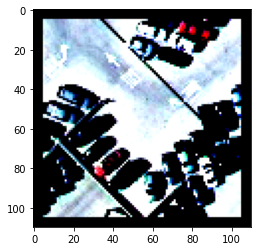

In [78]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

class UCMercedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=False):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for cat, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
        else:
          for cat, folder in enumerate(os.listdir(os.path.join(self.root))):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
 
        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
        
        def __str__(self):
            print('meu dataset tem {} imagens'.format(len(self.img_list)))

# Exemplos das transformações de dado mais comuns.
# Para mais detalhes e outras funções, consulte https://pytorch.org/docs/stable/torchvision/transforms.html
def test_transforms(dataset, root, batch_size):
  transformer = [
  torchvision.transforms.ToTensor(), # converte a imagem para tensor
  #torchvision.transforms.CenterCrop(100), # faz um crop no centro da imagem de tamanho 100x100
  torchvision.transforms.RandomCrop((100,100)), # faz um crop aleatório de tamanho 100x100
  torchvision.transforms.RandomHorizontalFlip(p=0.5), # flipa a imagem horizontalmente com 50% de chance
  torchvision.transforms.RandomVerticalFlip(p=0.5), # flipa a imagem verticalmente com 50% de chance
  #torchvision.transforms.RandomRotation((90,180), resample=PIL.Image.BILINEAR), # aleatoriamente rotaciona a imagem entre 90 e 180 graus
  #torchvision.transforms.Resize((100,100), interpolation=PIL.Image.BICUBIC), # muda o tamanho da imagem para o tamanho definido
  torchvision.transforms.RandomApply( # aplica as transformações dentro do bloco com chance p
      [torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # normaliza a imagem conforme os valores definidos de média e desvio padrão
       torchvision.transforms.Pad(5, fill=0, padding_mode='constant')], # preenche 4 níveis de borda da imagem com zeros],
  p=0.5),
  ]
  transformer = torchvision.transforms.Compose(transformer)
  train = dataset(root=root, transform=transformer, train=True, calc_norm=False, has_norm=False)
  num_workers = 0
  train_iter = torch.utils.data.DataLoader(train,
                                batch_size, shuffle=False,
                                num_workers=num_workers) # criação do dataloader de treino

  for image, label in train_iter:
    img = torch.squeeze(image).permute(1, 2, 0).numpy()
    imshow(img)
    break

test_transforms(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), 1)